In [30]:
import zipfile
import os

# Path to your zip file
zip_path = r"C:\Users\danny\OneDrive\Desktop\xAIE\lora_core_finetune.zip"
unzip_dir = r"C:\Users\danny\OneDrive\Desktop\xAIE\lora_core_finetune"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print("Unzip completed!")


Unzip completed!


In [31]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from peft import PeftModel, PeftConfig

# Step 1: Load base model
base_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

# Step 2: Load your LoRA adapter on top of base
adapter_path = r"C:\Users\danny\OneDrive\Desktop\xAIE\lora_core_finetune\lora_core_finetune"
model = PeftModel.from_pretrained(base_model, adapter_path)

# Done!
print(model.config)


T5Config {
  "_attn_implementation_autoset": true,
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": true,
      "ma

In [32]:
import csv
import time
from WiseSpeak.prompts import get_explanation
from evaluation import calculate_elder_x_score

In [33]:
NEW_PROMPTS = [
    "How do I check if my fridge is too cold or too warm?",
    "What’s the easiest way to remember names at a party?",
    "How do I safely unplug electronics?",
    "What’s a simple way to label food containers?",
    "How do I schedule a video call with my family?",
    "How can I block scam calls on my phone?",
    "What should I do if I forget where I put my keys?",
    "How do I safely water houseplants?",
    "How can I ask my neighbor for help politely?",
    "What’s a good way to stretch my back in bed?",
    "How do I know if an email is a scam?",
    "What’s the safest way to lift something heavy?",
    "How can I tell if my batteries need changing?",
    "How do I adjust the brightness on my TV?",
    "What should I do if I spill water on my phone?",
    "How can I warm my hands if they’re always cold?",
    "How do I make a simple grocery list?",
    "What’s an easy way to open packaging with stiff fingers?",
    "How do I refill my pillbox each week?",
    "What can I do if I feel lonely at night?",
    "How do I make a phone call on speaker?",
    "How do I keep bananas from ripening too fast?",
    "What’s a safe way to clean the shower floor?",
    "How do I ask my doctor questions without feeling nervous?",
    "How do I close apps on my smartphone?",
    "What’s the best way to wipe down a TV screen?",
    "How do I know if the oven is off?",
    "What’s a simple snack if I feel low on energy?",
    "How do I turn on flashlight mode on my phone?",
    "How can I organize my keys better?",
    "What’s a gentle way to comb tangly hair?",
    "How do I put on socks without bending too far?",
    "What’s a relaxing way to spend 10 minutes before bed?",
    "How do I clean my dentures properly?",
    "What do I do if I can’t fall asleep?",
    "What should I do if I feel short of breath after walking?",
    "How can I set a weekly reminder for trash day?",
    "How do I wipe a window without leaving streaks?",
    "What’s a comfortable way to sit if my back hurts?",
    "How do I send a photo to someone from my phone?",
    "How can I keep track of my favorite TV shows?",
    "What should I do if my legs feel restless?",
    "How do I check voicemail on my phone?",
    "What’s a safe way to clean up broken glass?",
    "How can I remember to take a walk each day?",
    "How do I use a microwave timer?",
    "What should I do if my ears feel clogged?",
    "How do I ask someone to repeat themselves nicely?",
    "How do I turn off automatic updates on my tablet?",
    "What’s a fun way to keep my brain sharp each day?"
]


In [35]:
# 🔹 Meta
USER_NAME = "TestUser"
HOBBY = "gardening"  # adjust to test metaphor handling

# 🔹 Output File
OUTPUT_CSV = "evaluation_finetune_results.csv"

In [36]:
def generate_lora_response(prompt, style, tokenizer, model):
    input_text = f"{prompt} | style: {style}"
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)
    outputs = model.generate(**inputs, max_new_tokens=150)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [37]:
# 🔹 Evaluation Loop
STYLES = [["short", "simplify"]]
results = []

for prompt in NEW_PROMPTS:
    for style_list in STYLES:
        style_str = " + ".join(style_list).strip().lower()

        print(f"📌 Evaluating LoRA: ({prompt} | {style_str})")

        try:
            explanation = generate_lora_response(prompt, style_str, tokenizer, model)
            score, r, s, a, c = calculate_elder_x_score(explanation)
            s = max(0, s)
            c = max(0, c)

            results.append([prompt, style_str, score, r, s, a, c, explanation])
            time.sleep(1)

        except Exception as e:
            print(f"⚠️ Error: {e}")

# 🔹 Save to CSV
with open(OUTPUT_CSV, mode="w", newline='', encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Prompt", "Style", "Score", "Readability", "Simplicity", "Actionability", "Comfort", "Explanation"])
    writer.writerows(results)

print(f"✅ Evaluation complete! Results saved to: {OUTPUT_CSV}")

📌 Evaluating LoRA: (How do I check if my fridge is too cold or too warm? | short + simplify)
📌 Evaluating LoRA: (What’s the easiest way to remember names at a party? | short + simplify)
📌 Evaluating LoRA: (How do I safely unplug electronics? | short + simplify)
📌 Evaluating LoRA: (What’s a simple way to label food containers? | short + simplify)
📌 Evaluating LoRA: (How do I schedule a video call with my family? | short + simplify)
📌 Evaluating LoRA: (How can I block scam calls on my phone? | short + simplify)
📌 Evaluating LoRA: (What should I do if I forget where I put my keys? | short + simplify)
📌 Evaluating LoRA: (How do I safely water houseplants? | short + simplify)
📌 Evaluating LoRA: (How can I ask my neighbor for help politely? | short + simplify)
📌 Evaluating LoRA: (What’s a good way to stretch my back in bed? | short + simplify)
📌 Evaluating LoRA: (How do I know if an email is a scam? | short + simplify)
📌 Evaluating LoRA: (What’s the safest way to lift something heavy? | shor

C:\Users\danny\AppData\Local\Temp\ipykernel_48340\1758692281.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Prompt", y="Score", data=df, palette="viridis")


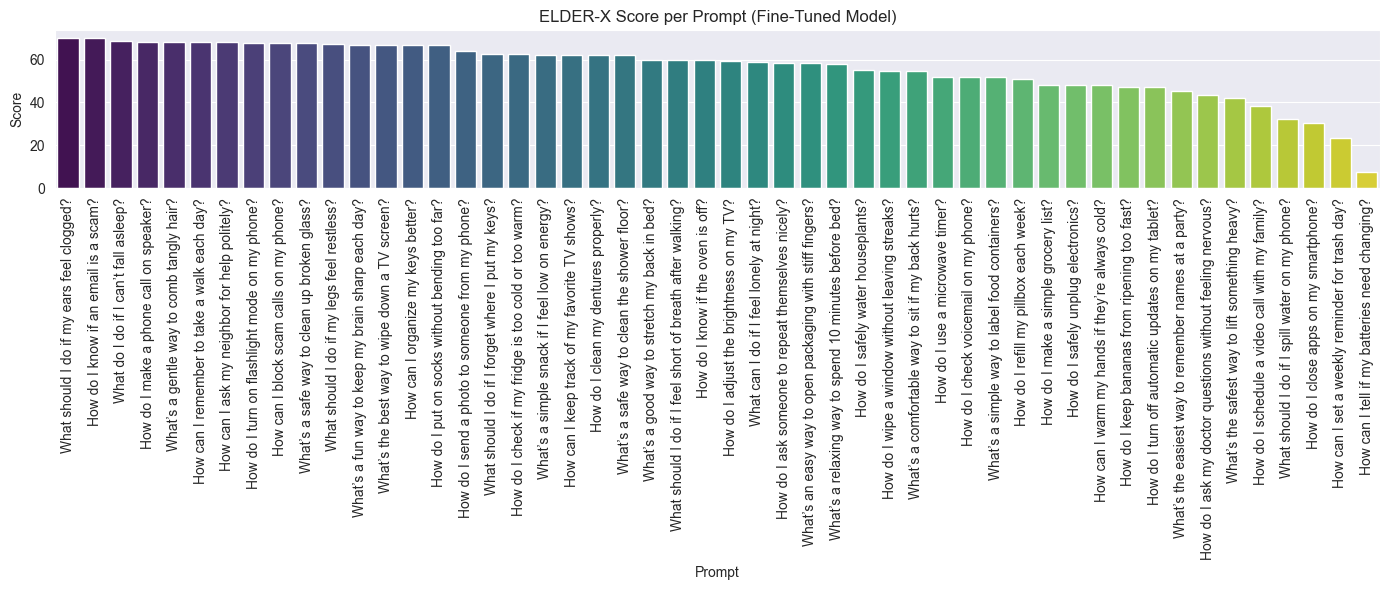

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your evaluation results
df = pd.read_csv("evaluation_finetune_results.csv")

# Sort by score
df = df.sort_values(by="Score", ascending=False)

# Plot overall ELDER-X Score
plt.figure(figsize=(14, 6))
sns.barplot(x="Prompt", y="Score", data=df, palette="viridis")
plt.title("ELDER-X Score per Prompt (Fine-Tuned Model)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [39]:
# Load the CSV
df = pd.read_csv("evaluation_finetune_results.csv")

# Show selected columns neatly
display_columns = ["Prompt", "Score", "Readability", "Simplicity", "Actionability", "Comfort", "Explanation"]
df[display_columns].style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])


,Prompt,Score,Readability,Simplicity,Actionability,Comfort,Explanation
0,How do I check if my fridge is too cold or too warm?,62.800000,100.000000,76.000000,0,0,"Check the temperature of the fridge. If it is too cold, it is too warm. If it is too warm, it is too cold."
1,What’s the easiest way to remember names at a party?,45.300000,48.000000,87.000000,0,0,Using a simple name system can help you remember names at a party.
2,How do I safely unplug electronics?,48.200000,56.000000,86.000000,0,0,Use a screwdriver to unscrew the wires from the bottom of the power cord.
3,What’s a simple way to label food containers?,51.900000,60.000000,93.000000,0,0,a simple way to label food containers?
4,How do I schedule a video call with my family?,38.100000,33.000000,83.000000,0,0,"Click on the ""Schedule a video call"" button and select ""Schedule a video call"" from the menu."
5,How can I block scam calls on my phone?,67.600000,100.000000,92.000000,0,0,How to block scam calls on your phone
6,What should I do if I forget where I put my keys?,62.800000,84.000000,84.000000,20,0,"If you forget where you put your keys, you should try to find them somewhere else."
7,How do I safely water houseplants?,54.900000,72.000000,87.000000,0,0,"To safely water houseplants, you should use a hose or a garden hose."
8,How can I ask my neighbor for help politely?,68.200000,100.000000,94.000000,0,0,Ask for help from your neighbor.
9,What’s a good way to stretch my back in bed?,59.700000,84.000000,87.000000,0,0,Stretching your back in bed can help you relax and relax your back.


In [40]:
average_score = df["Score"].mean()
average_readability = df["Readability"].mean()
average_simplicity = df["Simplicity"].mean()
average_actionability = df["Actionability"].mean()
average_comfort = df["Comfort"].mean()

In [41]:
print("Average ELDER-X Scores (Fine-Tuned Model)")
print(f"Score:         {average_score:.2f}")
print(f"Readability:   {average_readability:.2f}")
print(f"Simplicity:    {average_simplicity:.2f}")
print(f"Actionability: {average_actionability:.2f}")
print(f"Comfort:       {average_comfort:.2f}")


Average ELDER-X Scores (Fine-Tuned Model)
Score:         56.03
Readability:   75.56
Simplicity:    86.08
Actionability: 1.40
Comfort:       0.10
